# Online Payments Fraud Detection

This project goals are:

- Provide an analysis on the data.
- Create a model based on classification to detect fraudulent payments.
- Use hypotetical testing to check for reliable results from models.

Online payment frauds are one of the main risks of e-Commerce, in 2021, $ 20 billions were estimated to be lost by fraudulent transactions according to [Juniper research](https://www.juniperresearch.com/infographics/online-payment-fraud-statistics). Also according to [Juniper](https://www.juniperresearch.com/infographics/online-payment-fraud-statistics), most of the frauds are US based, with a rapid growth of frauds in China. This is due to mainly three points, the pandemic forced stores to move to e-Commerce which have frauds they are not prepared for, data breaches and fraudsters using machine learning to enhance the practice.

According to [Merchant Savvy](https://www.merchantsavvy.co.uk/payment-fraud-statistics/), companies that invest in a fraud detection program have reduced attack response expenses by 42%, reduced by 17% the investment in prevention, also reducing by 16% the amount of fines/penalties payed with such a program. In South America alone, according to [MRC](https://www.ravelin.com/insights/online-payment-fraud), 2.8% of suspected transactions were saved by having proper sistems in place.

The dataset used for this study is available on Kaggle, you can check it [here](https://www.kaggle.com/datasets/ealaxi/paysim1), it is composed by artificial data sourced from the [PaySim](https://github.com/EdgarLopezPhD/PaySim), a mobile money payment simulator.

## Downloading the dataset

First, let's download the dataset into the directory the notebook is running.

The dataset is composed by only one csv file, which can be done easily with the following code.

**WARNING**

Don't forget to generate a API key with your Kaggle account, this process can be done by accessing your profile on the "Account" tab, you will generate a .json file with your account name and key, that should be provided in order to download the dataset through this method.

In [1]:
# Run this cell in case you don't have the required packages
%pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as ods

In [3]:
ods.download("https://www.kaggle.com/datasets/ealaxi/paysim1")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: romulopeixoto
Your Kaggle Key: ··········


100%|██████████| 178M/178M [00:05<00:00, 35.7MB/s]


## Exploratory Data Analysis

Now that the dataset is downloaded, let's start understanding the data a litte better.

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, recall_score, accuracy_score, SCORERS
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv("paysim1/PS_20174392719_1491204439457_log.csv")

In [6]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

After this first commands, is possible to conclude that is a large number of observations and that not a single row has a empty value.

Another conclusion is that "nameOrig" and "nameDest" is a mixed type of value, maybe splitting information can give us some useful gain.

But first let's analyze the numerical features.

### Univariate analysis

This section is dedicated to univariate analysis.

#### Numerical data

Starting with a five number summary adding the median, skewness and kurtosis of only numerical features in the dataset.

In [9]:
data_skew = data.skew(axis = 0)
data_kurt = data.kurt(axis = 0)
data_median = data.median()
data.describe().T.assign(skewness = data_skew, kurtosis = data_kurt, median = data_median)

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis,median
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02,0.375177,0.329071,239.000
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07,30.993949,1797.956705,74871.940
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07,5.249136,32.964879,14208.000
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07,5.176884,32.066985,0.000
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08,19.921758,948.674125,132705.665
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08,19.352302,862.156508,214661.440
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00,27.779538,769.702982,0.000
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00,630.603629,397659.062500,0.000


Here is possible to see how spread the data is, the "step" feature is a measure of time, it will be transformed later into a something workable, "isFraud" and "isFlaggedFraud" are both categorical, despite being encoded already.

The other features are truly numerical and have a very unique shape, let's visualize them.

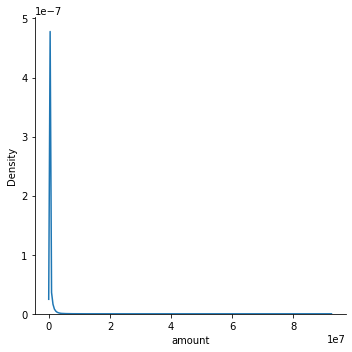

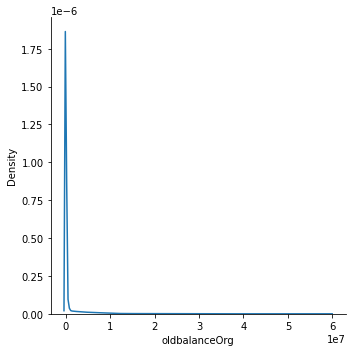

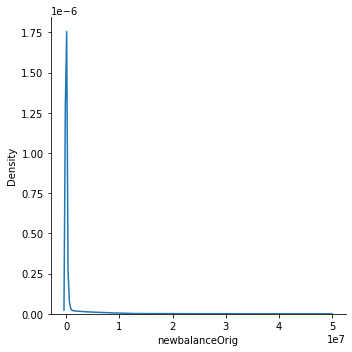

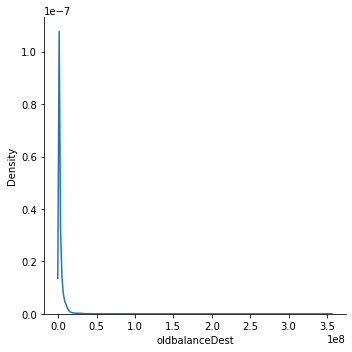

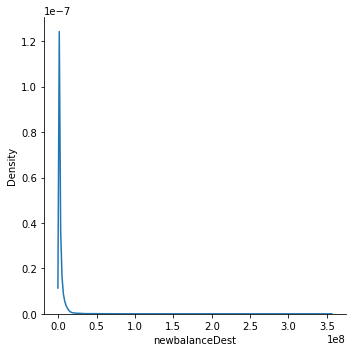

In [10]:
for column in ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]:
    sns.displot(data[column], kind="kde");
    plt.show()

This result shows that data is highly uneven and require some treatment to be ready to be implmented on a model, since this dataset require a classification kind of algorithm, it's important to data to be scaled properly due to information gain.

The solution for this kind of problem is that the shape of the distribuition requires change, not only to be rescaled, since there are a number of rescaling techniques, here will be compared only three, Normalization, Logarithm transformation and  Box Cox. This is a technique that will be tested in order to use a more wide range of classification algorithms.

In [11]:
num_data = np.array(data[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]])

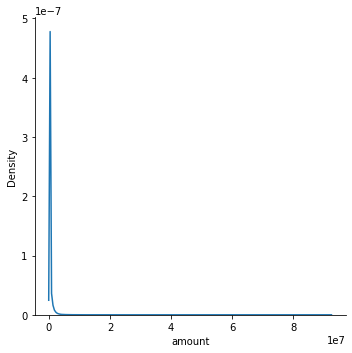

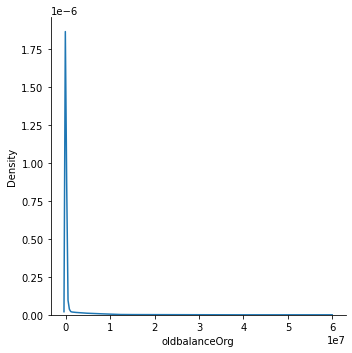

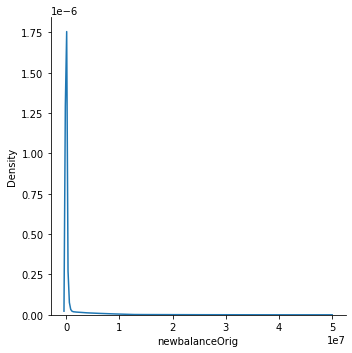

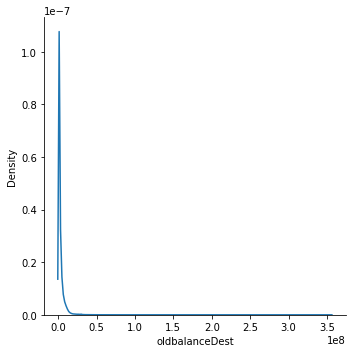

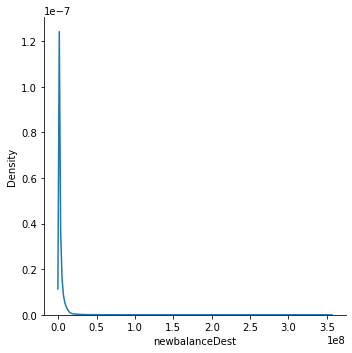

In [12]:
i = 0
columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for column in columns:
  if i < len(columns):
    sns.displot(num_data[0:, i], kind="kde");
    plt.xlabel(xlabel = columns[i])
    plt.show()
    i += 1

In [13]:
# Normalized data
norm_num_data = normalize(num_data)

In [14]:
norm_num_data

array([[0.04205666, 0.72719646, 0.6851398 , 0.        , 0.        ],
       [0.06468038, 0.73722482, 0.67254443, 0.        , 0.        ],
       [0.70710678, 0.70710678, 0.        , 0.        , 0.        ],
       ...,
       [0.57525073, 0.57525073, 0.        , 0.00624239, 0.58149311],
       [0.70710678, 0.70710678, 0.        , 0.        , 0.        ],
       [0.08586432, 0.08586432, 0.        , 0.65762772, 0.74349204]])

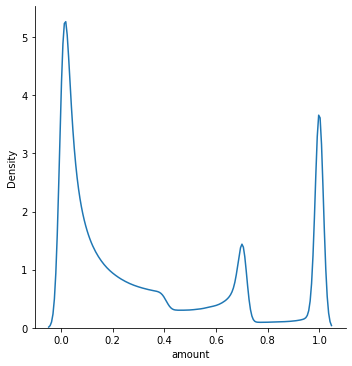

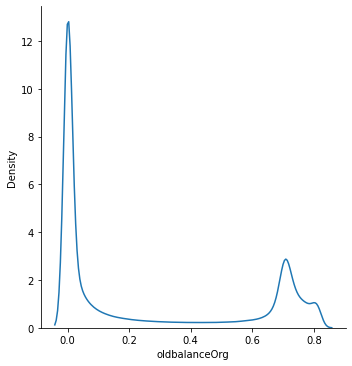

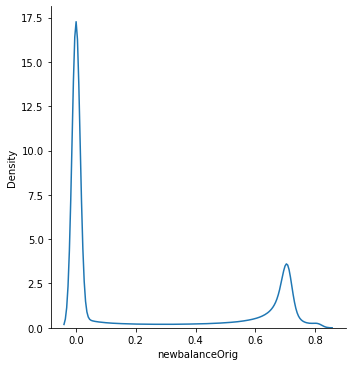

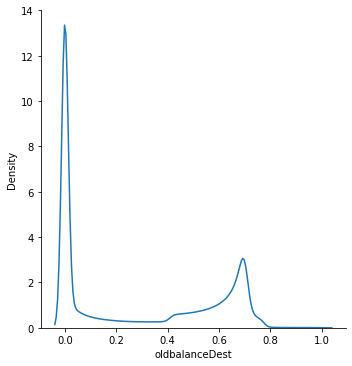

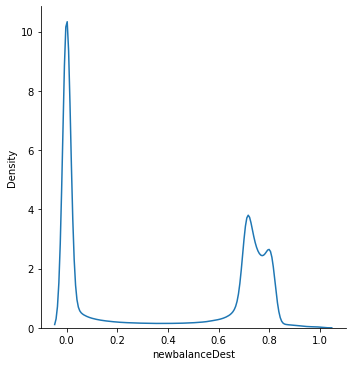

In [15]:
i = 0
columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for column in columns:
  if i < len(columns):
    sns.displot(norm_num_data[0:, i], kind="kde");
    plt.xlabel(xlabel = columns[i])
    plt.show()
    i += 1

In [16]:
# Box-cox transformation, in Scikit-learn, the methos used is Yeo-Johnson method, paper can be found in Scikit-Learn docs.
pt = PowerTransformer(standardize = False)

In [17]:
bc_num_data = pt.fit_transform(num_data)

In [18]:
bc_num_data

array([[16.07735023, 14.94437566,  7.64103482,  0.        ,  0.        ],
       [11.82702501, 11.89877568,  6.77523202,  0.        ,  0.        ],
       [ 7.0642614 ,  5.70229776, -0.        ,  0.        ,  0.        ],
       ...,
       [42.65333822, 20.78532432, -0.        , 13.93320469, 28.07020687],
       [32.27725269, 17.45459622, -0.        ,  0.        ,  0.        ],
       [32.27725269, 17.45459622, -0.        , 21.61466058, 28.48948268]])

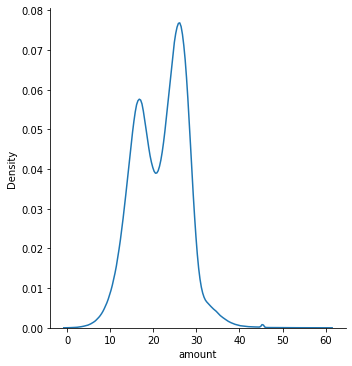

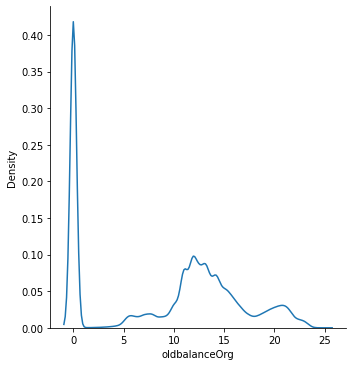

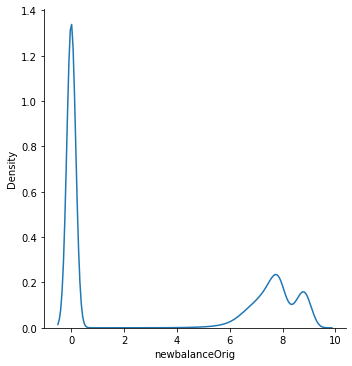

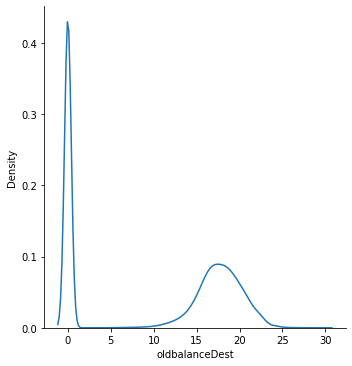

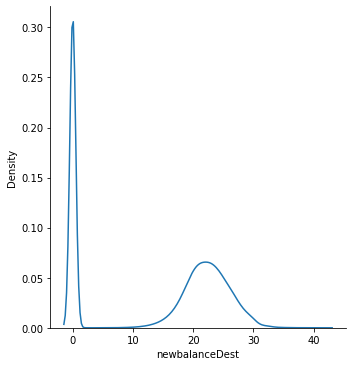

In [19]:
i = 0
columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for column in columns:
  if i < len(columns):
    sns.displot(x = bc_num_data[0:, i], kind="kde");
    plt.xlabel(xlabel = columns[i])
    plt.show()
    i += 1

In [20]:
# Logarithm transformation
log_num_data = np.log(num_data)

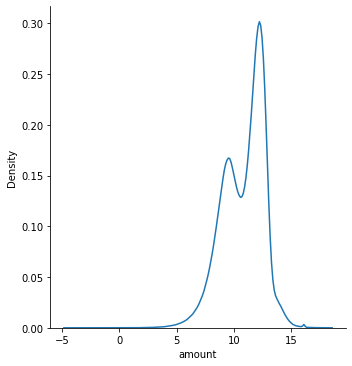

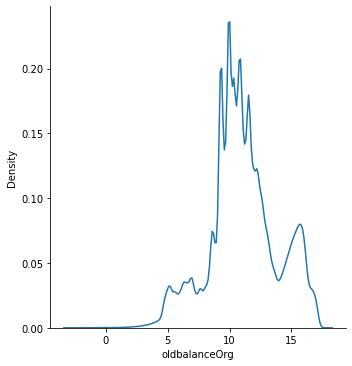

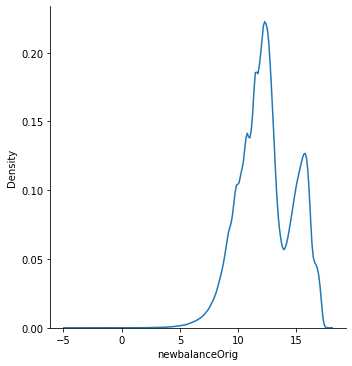

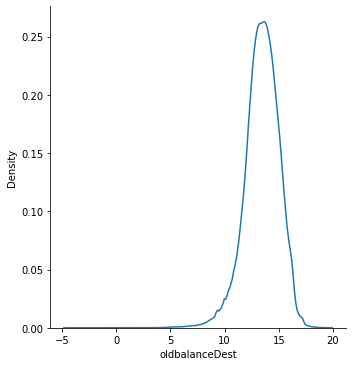

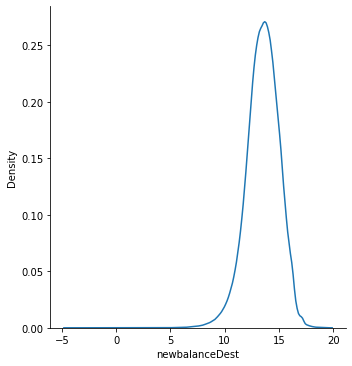

In [21]:
i = 0
columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for column in columns:
  if i < len(columns):
    sns.displot(x = log_num_data[0:, i], kind="kde");
    plt.xlabel(xlabel = columns[i])
    plt.show()
    i += 1

After transforming the data is important to point out that the distribuitions follow a multi modal distribuitions, in order to figure out if is the kernel density estimations is over estimating the lower density, a violin plot to figure out how if the data is really with two tendencies.

The log transformation won't be ploted to the existence of infity results on the array.

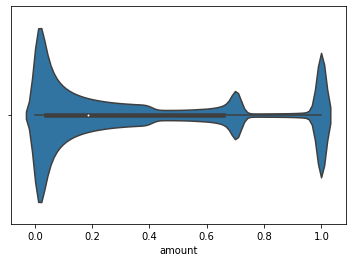

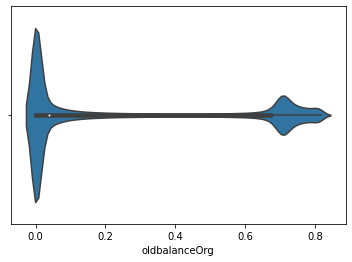

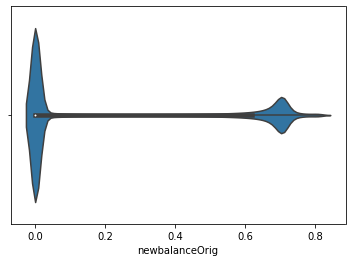

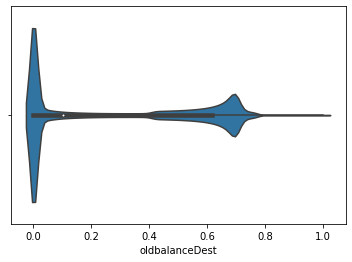

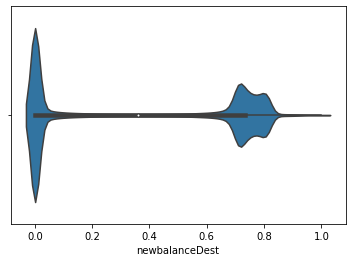

In [22]:
i = 0
columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for column in columns:
  if i < len(columns):
    sns.violinplot(x = norm_num_data[0:, i]);
    plt.xlabel(xlabel = columns[i])
    plt.show()
    i += 1

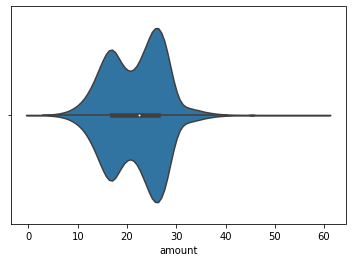

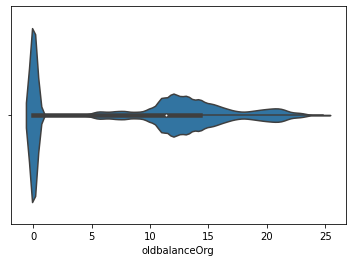

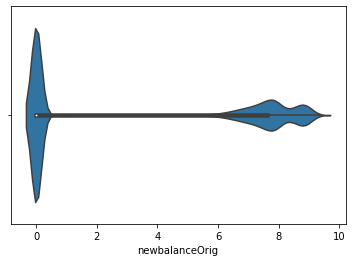

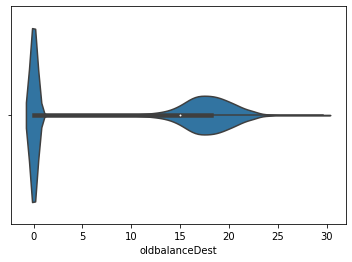

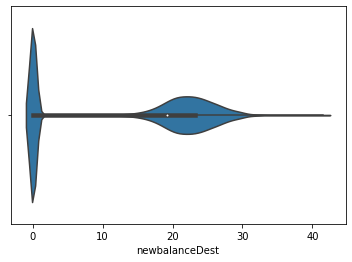

In [23]:
i = 0
columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for column in columns:
  if i < len(columns):
    sns.violinplot(x = bc_num_data[0:, i]);
    plt.xlabel(xlabel = columns[i])
    plt.show()
    i += 1

The distribuition confirms the existance of two tendencies on the transformed numerical data, to understand the behaviour and which is more likely to be an outrlier a Q-Q plot will be calculated in order to understand where there might be more outliers.

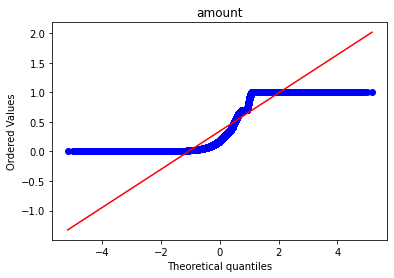

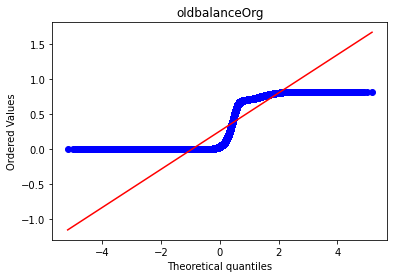

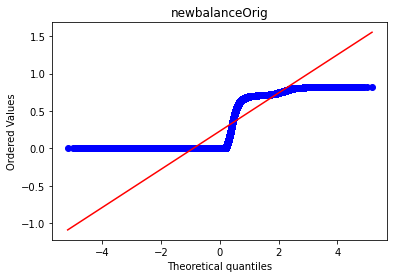

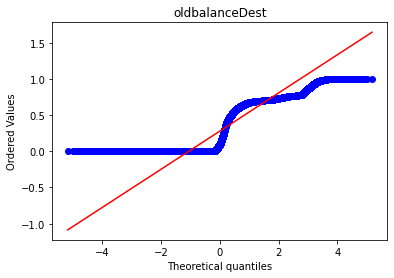

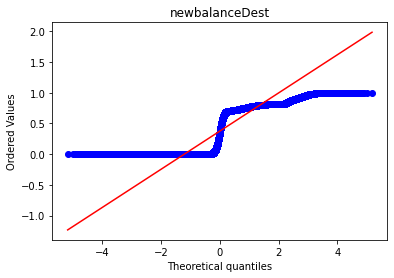

In [24]:
i = 0
columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for column in columns:
  if i < len(columns):
    stats.probplot(x = norm_num_data[0:, i], plot=plt);
    plt.title(columns[i])
    plt.show()
    i += 1

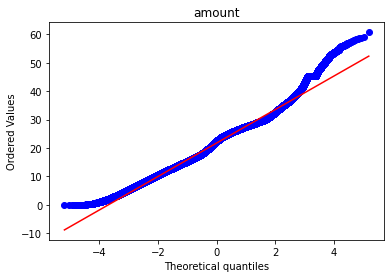

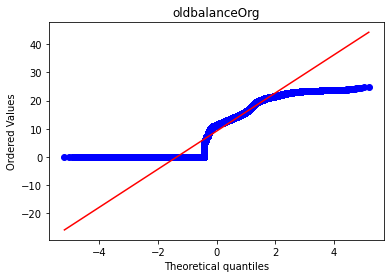

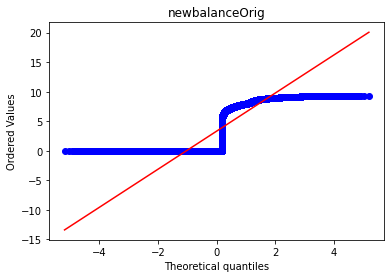

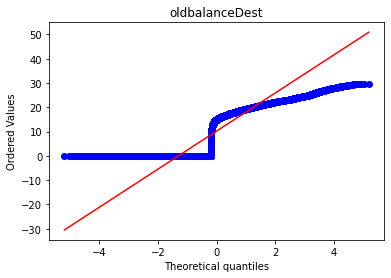

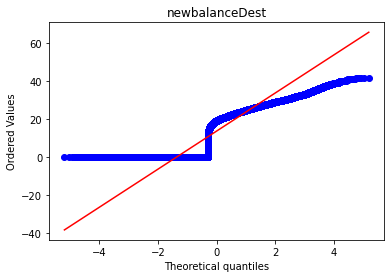

In [25]:
i = 0
columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for column in columns:
  if i < len(columns):
    stats.probplot(x = bc_num_data[0:, i], plot=plt);
    plt.title(columns[i])
    plt.show()
    i += 1

After this plot is clear that the probability of outliers is in higher values and that is easier to visualize when data is not standardized. After this analysis a conclusion is that changing the vector space of the data may lead to information gain.

In order to test it out, the normalization will occur not using the standard l2 normalization but using a max value as normalization function.

In [26]:
max_norm_num_data = normalize(num_data, norm="max")

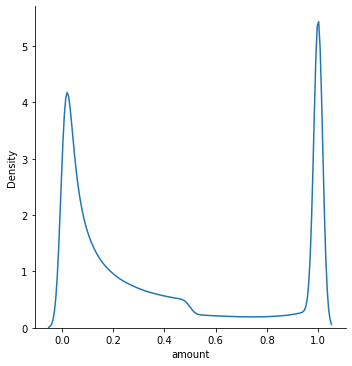

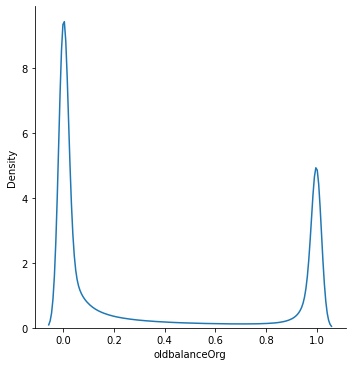

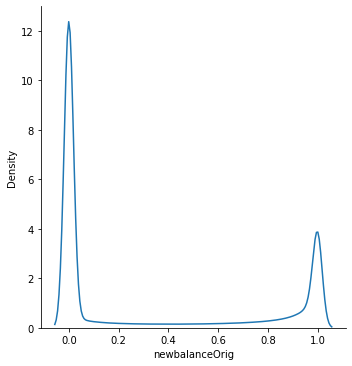

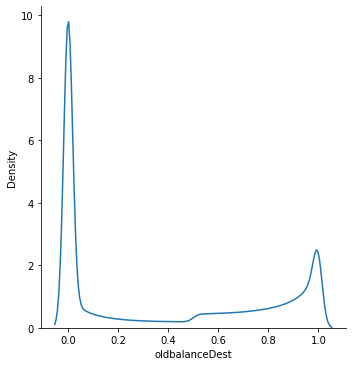

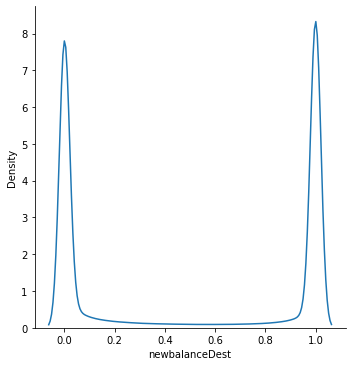

In [27]:
i = 0
columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for column in columns:
  if i < len(columns):
    sns.displot(x = max_norm_num_data[0:, i], kind="kde");
    plt.xlabel(xlabel = columns[i])
    plt.show()
    i += 1

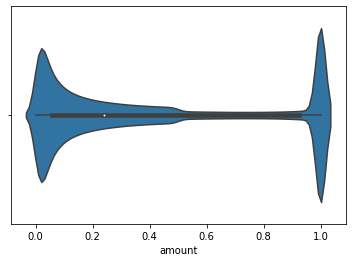

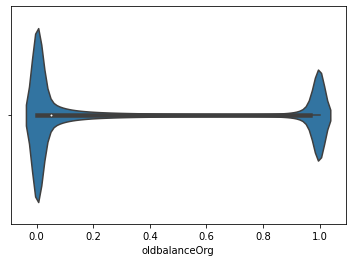

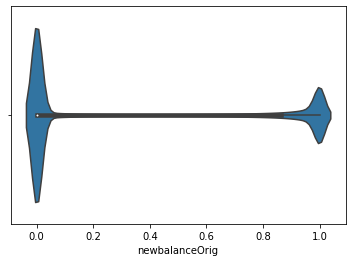

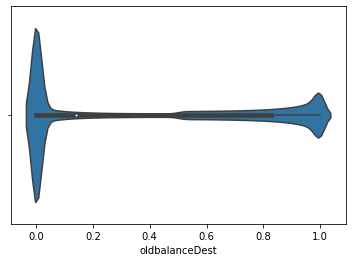

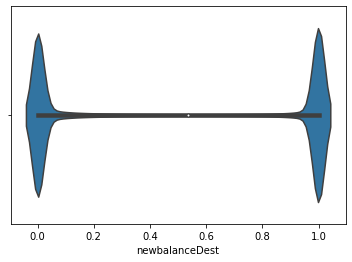

In [28]:
i = 0
columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for column in columns:
  if i < len(columns):
    sns.violinplot(x = max_norm_num_data[0:, i]);
    plt.xlabel(xlabel = columns[i])
    plt.show()
    i += 1

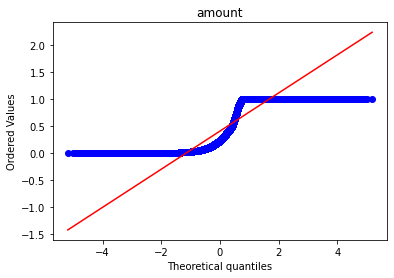

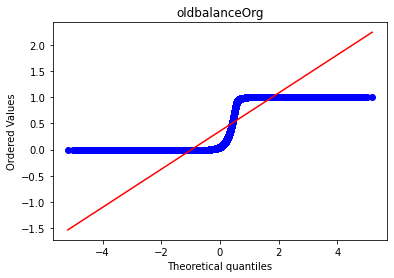

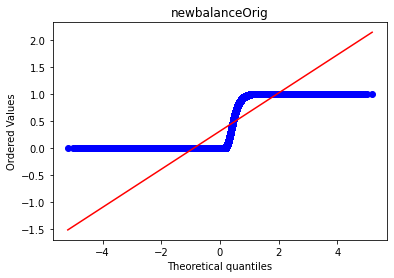

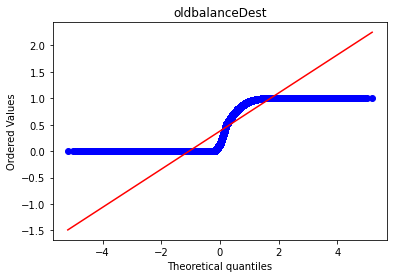

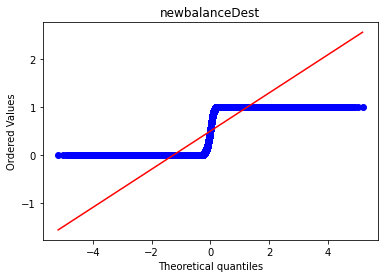

In [29]:
i = 0
columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for column in columns:
  if i < len(columns):
    stats.probplot(x = max_norm_num_data[0:, i], plot=plt);
    plt.title(columns[i])
    plt.show()
    i += 1

Despite still having a standardization of the values, utilizaing max norm made clearer that in fact data assumes a shape of bimodal distribuition with a probably non-linear genration of the data.

#### Categorical data

Now it's time to analyze the categorical data in order to understand their behaviour, start by selecting the features to work with.

In [30]:
cat_data = data[["type", "isFraud", "isFlaggedFraud"]]

In [31]:
cat_data.head()

,type,isFraud,isFlaggedFraud
0,PAYMENT,0,0
1,PAYMENT,0,0
2,TRANSFER,1,0
3,CASH_OUT,1,0
4,PAYMENT,0,0


In [32]:
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   type            object
 1   isFraud         int64 
 2   isFlaggedFraud  int64 
dtypes: int64(2), object(1)
memory usage: 145.6+ MB


In order to treat "isFraud" and "isFlaggedFraud" as labels, conversion from int64 to string is required.

In [33]:
cat_data[["isFraud", "isFlaggedFraud"]] = cat_data[["isFraud", "isFlaggedFraud"]].astype(str)

In [34]:
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   type            object
 1   isFraud         object
 2   isFlaggedFraud  object
dtypes: object(3)
memory usage: 145.6+ MB


In [35]:
cat_data.describe()

,type,isFraud,isFlaggedFraud
count,6362620,6362620,6362620
unique,5,2,2
top,CASH_OUT,0,0
freq,2237500,6354407,6362604


The major take away of this table is that the target variable is highly unbalanced. This will be a problem later on generalization of the model, due to this is important to point out that some sort of sampling method need to be applied before training in order to get the best results in production.

Some visualization is required mostly to check how is the division on the type of operation performed.

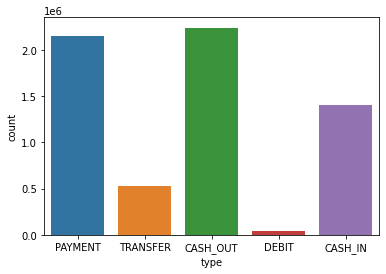

In [36]:
sns.countplot(cat_data["type"]);

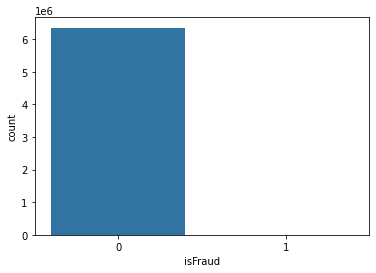

In [37]:
sns.countplot(cat_data["isFraud"]);

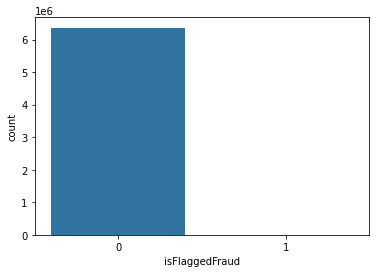

In [38]:
sns.countplot(cat_data["isFlaggedFraud"]);

Visualization confirmed an immense imbalance in the dataset.

Also, "CASH_IN" and "PAYMENT" have a meaningful representation on the dataset.

### Multivariate analysis

Checking how the variables are correlated along the dataset. In order to evaluate the labels, the "type" feature will be encoded into numerical values to evaluate the correlation with other features.

In [39]:
encoded_data = pd.get_dummies(data, columns = ["type"], prefix = "type")

In [40]:
encoded_data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,0,1,0


The code for origin and destiny will also be dropped in order to reduce the amount of data being feed to correlation algorithms.

In [41]:
encoded_data.drop(["nameOrig", "nameDest"], axis=1, inplace=True)

Since data might have a non-linear approach, both Pearson and Spearman correlations will be computed and compared in order to check if variables have some degree of non-linear relationship.

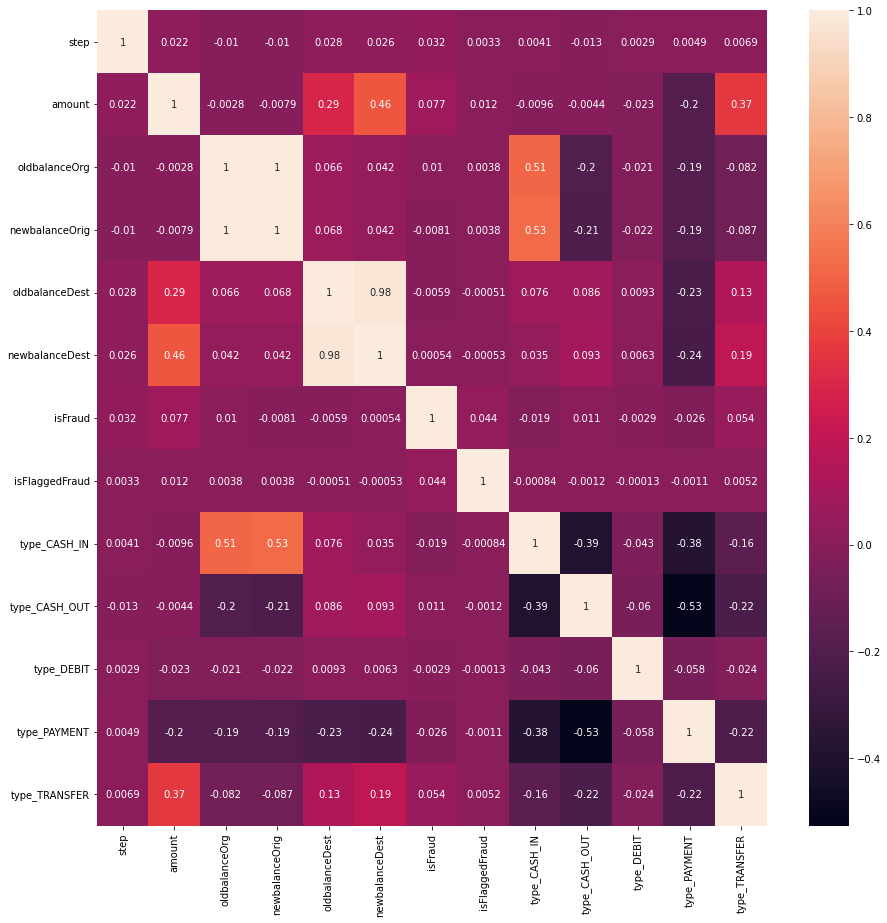

In [42]:
plt.figure(figsize=(15, 15))
sns.heatmap(encoded_data.corr(), annot = True);
plt.show()

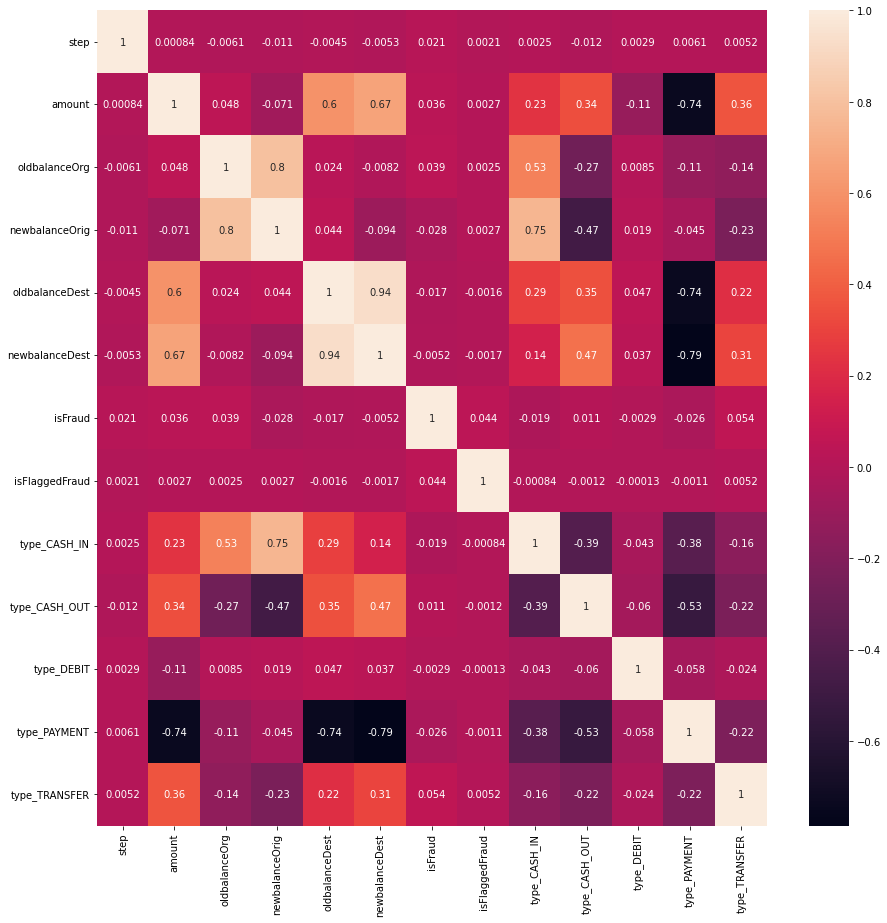

In [43]:
plt.figure(figsize=(15, 15))
sns.heatmap(encoded_data.corr(method="spearman"), annot = True);
plt.show()

After the plot, is possible to see that Spearman correlation has greater values on some correlations, this means that the relationship between variables on the dataset are better explained with non-linear models than linear, all other correlations stayed similar.

Visualizing all relationships may not be required, but is important to check how transactions values are related to the target variable.

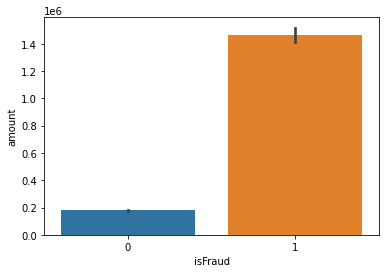

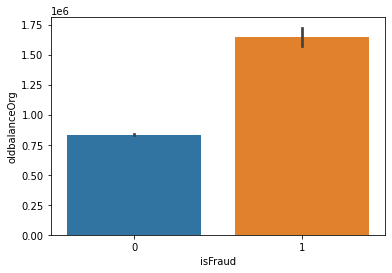

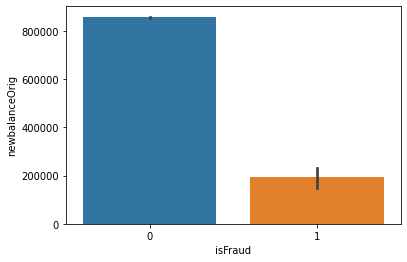

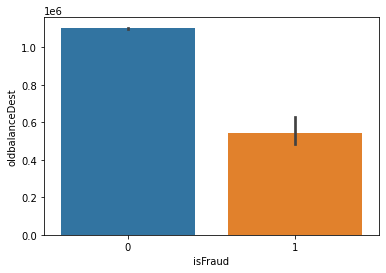

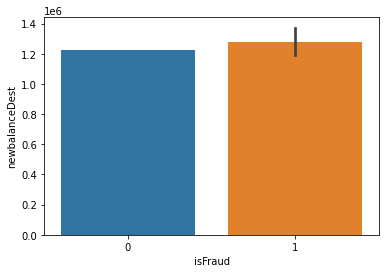

In [44]:
num_columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for column in num_columns:
  sns.barplot(data = encoded_data, x = encoded_data["isFraud"], y = encoded_data[column]);
  plt.show()

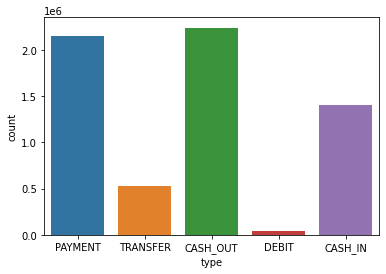

In [45]:
sns.countplot(data = data[["type", "isFraud"]].loc[data["isFraud"] == 1], x = data["type"]);

Is important to note the main source of frauds come from the PAYMENT and CASH-OUT type of transactions, those are based on transactions involving payments related to customers to merchants and payments made by the merchants to any other source.

This graph leads us to believe that not only customers are involved in fraudulent online payments, but also merchants have been victims of it too. Here is important to notice how the PAYMENT class is described, since all of the classes are related to some sort of payment, this class is described by having some sort of invoice involved in the process and you can link the transaction to actual products and storage merchants have in this case.

Another important characteristic of the most fraudulent transactions are how the CASH-OUT works, which means that merchants withdraw money from their accounts and use that money to pay some sort of spenditure with business, which means that not only customers are the focus of fraud.

Also, looking at the relationship between fraud and amount of money in the transaction, the mean is greater for fraudulent transactions with a relatively low standard deviation, which means that most transactions with big figures are more likely to be labelled as fraud.

## Model Building

Before moving forward, is important to recognize some capabilities that the model must have in order to perform fraud detection, usually, for supervised models on fraud analysis tree based methods are used based on interpretability, training time and prediction time, those are the main features an algorithm must have to be used on this kind of problem.

In this project three classification algorithms will be used, with different ways to use trees to label data, a simple decision tree, random forests and extreme gradient boosting trees. Also, a classification algorithm not based on trees will be used, k-Nearest neighbors. Algorithms will be trained used cross-validation scheme and an exaustice grid search to validate the model.

The metric used to optimize the models will be recall, since it evaluates the rate of false negative labels the model predicts.

Performance will also be evaluated in terms of resampling method, since the dataset is highly inbalanced, strategies to understand which method makes algorithms work best.

After building the models, a hipothesys analysis will be carried out to understand the validity of each model.

In [46]:
encoded_data

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,0,0,1,0
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,0,0,1,0
2,1,181.00,181.00,0.00,0.00,0.00,1,0,0,0,0,0,1
3,1,181.00,181.00,0.00,21182.00,0.00,1,0,0,1,0,0,0
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,1,0,0,1,0,0,0
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,1,0,0,0,0,0,1
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,0,1,0,0,0
6362618,743,850002.52,850002.52,0.00,0.00,0.00,1,0,0,0,0,0,1


Below the "isFlaggedFraud" will be dropped since it is flagged all the transactions with amount over $200,000 and this don't bring any real information gain to the analysis and increase computaion time.

In [47]:
encoded_data.drop(columns = "isFlaggedFraud", axis=1)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,0,1,0
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,0,1,0
2,1,181.00,181.00,0.00,0.00,0.00,1,0,0,0,0,1
3,1,181.00,181.00,0.00,21182.00,0.00,1,0,1,0,0,0
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,1,0,1,0,0,0
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,1,0,0,0,0,1
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,1,0,0,0
6362618,743,850002.52,850002.52,0.00,0.00,0.00,1,0,0,0,0,1


In [48]:
encoded_data.columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'type_CASH_IN',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

In [49]:
X = np.array(encoded_data[["step", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest",
       "newbalanceDest", "type_CASH_IN", "type_CASH_OUT", "type_DEBIT", "type_PAYMENT", "type_TRANSFER"]])

In [50]:
y = np.array(encoded_data["isFraud"])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

This first split will be carried out in a classical sense, to check the performance of the model, although, the balance of labels will be preserved in each dataset.

#### Default Decision trees

This section will be dedicated to train an algorithm with decision trees and no treatment of imbalance of the dataset and no cross validation as base for comparison.

In [53]:
dt_cls = DecisionTreeClassifier(random_state=0)

In [54]:
dt_cls.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [55]:
dt_y_pred = dt_cls.predict(X_test)

In [56]:
print(classification_report(y_test, dt_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.89      0.86      0.87      1643

    accuracy                           1.00   1272524
   macro avg       0.94      0.93      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



#### Default Random Forests

This section will be dedicated to train an algorithm with random forests and no treatment of imbalance of the dataset and no cross validation as base for comparison.

In [57]:
rf_cls = RandomForestClassifier(random_state=0)

In [58]:
rf_cls.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [59]:
rf_y_pred = rf_cls.predict(X_test)

In [60]:
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.98      0.76      0.86      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.88      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524



#### Default Extreme Gradient Boosting Trees

This section will be dedicated to train an algorithm with extreme gradient boosting trees and no treatment of imbalance of the dataset and no cross validation as base for comparison.

In [61]:
gb_cls = GradientBoostingClassifier(random_state=0)

In [62]:
gb_cls.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [63]:
gb_y_pred = gb_cls.predict(X_test)

In [64]:
print(classification_report(y_test, gb_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.82      0.21      0.34      1643

    accuracy                           1.00   1272524
   macro avg       0.91      0.61      0.67   1272524
weighted avg       1.00      1.00      1.00   1272524



#### Default k-Nearest Neighbours

This section will be dedicated to train an algorithm with k-nearest neighbours and no treatment of imbalance of the dataset and no cross validation as base for comparison.

In [65]:
knn_cls = KNeighborsClassifier()

In [66]:
knn_cls.fit(X_train, y_train)

KNeighborsClassifier()

In [67]:
knn_y_pred = knn_cls.predict(X_test)

In [68]:
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.87      0.65      0.74      1643

    accuracy                           1.00   1272524
   macro avg       0.93      0.82      0.87   1272524
weighted avg       1.00      1.00      1.00   1272524



#### Default results

The results of the models can be observed on the table below:

| Model | Recall |
|:------|:-------|
| Decision Tree | 0.87 |
| Random Forest | 0.77 |
| Extreme Gradient Boosting Trees | 0.35 |
| k-Nearest Neighbors | 0.67 |

The best model on the default implementation of the algorithms was one simple Decision Tree, this can be explained by the complexity of the models may be taking into factor and also the goal of the default implementation.

### Evaluating with cross validation

Testing the algorithms training with cross validation to check if results are improved.

#### Decision Trees

In [69]:
dt_scores = cross_val_score(dt_cls, X_test, y_test, cv=5, scoring="recall_macro", n_jobs=-1)

In [70]:
dt_cv_mean_score = dt_scores.mean()
dt_cv_std_score = dt_scores.std()
print(f"Decision Trees CV\nMean:{dt_cv_mean_score:.2f}\nStandard Deviation:{dt_cv_std_score:.2f}")

Decision Trees CV
Mean:0.91
Standard Deviation:0.02


#### Random Forests

In [71]:
rf_scores = cross_val_score(rf_cls, X_test, y_test, cv=5, scoring="recall_macro", n_jobs=-1)

In [72]:
rf_cv_mean_score = rf_scores.mean()
rf_cv_std_score = rf_scores.std()
print(f"Random Forests CV\nMean:{rf_cv_mean_score:.2f}\nStandard Deviation:{rf_cv_std_score:.2f}")

Random Forests CV
Mean:0.87
Standard Deviation:0.01


#### Extreme Gradient Boosting Trees

In [73]:
gb_scores = cross_val_score(gb_cls, X_test, y_test, cv=5, scoring="recall_macro", n_jobs=-1)

In [74]:
gb_cv_mean_score = gb_scores.mean()
gb_cv_std_score = gb_scores.std()
print(f"Extreme Gradient Boosting Trees CV\nMean:{gb_cv_mean_score:.2f}\nStandard Deviation:{gb_cv_std_score:.2f}")

Extreme Gradient Boosting Trees CV
Mean:0.65
Standard Deviation:0.10


#### k-Nearest Neighbours

In [75]:
knn_scores = cross_val_score(knn_cls, X_test, y_test, cv=5, scoring="recall_macro", n_jobs=-1)

In [76]:
knn_cv_mean_score = knn_scores.mean()
knn_cv_std_score = knn_scores.std()
print(f"k-Nearest Neighbours CV\nMean:{knn_cv_mean_score:.2f}\nStandard Deviation:{knn_cv_std_score:.2f}")

k-Nearest Neighbours CV
Mean:0.79
Standard Deviation:0.02


#### Cross validation results

The results of the models can be observed on the table below:

| Model | Recall | CV Recall |
|:------|:-------|:-------|
| Decision Tree | 0.87 | 0.91 |
| Random Forest | 0.77 | 0.88 |
| Extreme Gradient Boosting Trees | 0.35 | 0.77 |
| k-Nearest Neighbors | 0.67 | 0.88 |

The best model at this point is still a Decision Tree, using cross-validation to evaluate the capacity of generalization of the models, overall, all models have shown a increase in performance, but in a real world environment, only the Decision Tree is showing relevant performance.

### Training with cross validation

In [77]:
scoring = ["accuracy", "recall_macro"]

#### Decision Trees

In [78]:
dt_cv_cls = DecisionTreeClassifier(random_state=0)

In [79]:
dt_cv_train = cross_validate(dt_cv_cls, X_train, y_train, scoring=scoring, n_jobs=-1)
dt_cv_fit_time = dt_cv_train["fit_time"].mean()
dt_cv_accuracy = dt_cv_train["test_accuracy"].mean()
dt_cv_recall = dt_cv_train["test_recall_macro"].mean()

In [80]:
print(f"Decision Tree\n\
Fit Time:{dt_cv_fit_time:.2f}\n\
Accuracy:{dt_cv_accuracy:.4f}\n\
Recall:{dt_cv_recall:.4f}")

Decision Tree
Fit Time:49.97
Accuracy:0.9997
Recall:0.9297


#### Random Forests

In [81]:
rf_cv_cls = RandomForestClassifier(random_state=0)

In [82]:
rf_cv_train = cross_validate(rf_cv_cls, X_train, y_train, scoring=scoring, n_jobs=-1)
rf_cv_fit_time = rf_cv_train["fit_time"].mean()
rf_cv_accuracy = rf_cv_train["test_accuracy"].mean()
rf_cv_recall = rf_cv_train["test_recall_macro"].mean()

In [83]:
print(f"Random Forests\n\
Fit Time:{rf_cv_fit_time:.2f}\n\
Accuracy:{rf_cv_accuracy:.4f}\n\
Recall:{rf_cv_recall:.4f}")

Random Forests
Fit Time:848.77
Accuracy:0.9997
Recall:0.8918


#### Extreme Gradient Boosting Trees

In [84]:
gb_cv_cls = GradientBoostingClassifier(random_state=0)

In [85]:
gb_cv_train = cross_validate(gb_cv_cls, X_train, y_train, scoring=scoring, n_jobs=-1)
gb_cv_fit_time = gb_cv_train["fit_time"].mean()
gb_cv_accuracy = gb_cv_train["test_accuracy"].mean()
gb_cv_recall = gb_cv_train["test_recall_macro"].mean()

KeyboardInterrupt: ignored

In [ ]:
print(f"Extreme Gradient Boosting Trees\n\
Fit Time:{gb_cv_fit_time:.2f}\n\
Accuracy:{gb_cv_accuracy:.4f}\n\
Recall:{gb_cv_recall:.4f}")

#### k-Nearest Neighbours

In [ ]:
knn_cv_cls = KNeighborsClassifier()

In [ ]:
knn_cv_train = cross_validate(knn_cv_cls, X_train, y_train, scoring=scoring, n_jobs=-1)
knn_cv_fit_time = knn_cv_train["fit_time"].mean()
knn_cv_accuracy = knn_cv_train["test_accuracy"].mean()
knn_cv_recall = knn_cv_train["test_recall_macro"].mean()

In [ ]:
print(f"k-Nearest Neighbours\n\
Fit Time:{knn_cv_fit_time:.2f}\n\
Accuracy:{knn_cv_accuracy:.4f}\n\
Recall:{knn_cv_recall:.4f}")

The results of the models can be observed on the table below:

| Model | Recall | CV Recall | CV train Recall | 
|:------|:-------|:-------|:-------|
| Decision Tree | 0.87 | 0.91 | 0.93 |
| Random Forest | 0.77 | 0.88 | 0.89 |
| Extreme Gradient Boosting Trees | 0.35 | 0.77 | 0.68 |
| k-Nearest Neighbors | 0.67 | 0.88 | 0.83 |

At this point, using cross validation to train a model from scratch have shown a decrease in performance for Gradient Boosting Trees and Nearest Neighbours, but an increase for Random Forest and the Decision Tree. 

### Grid search CV

Now is time to look for the best parameters of each model and evaluate the performances. The models used to validate are the ones already trained in the first part, since Grid search already uses cross-validation to train models.

#### Decision Tree

In [86]:
dt_parameters = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "ccp_alpha": [x for x in np.arange(0, 1, 0.1)]
}

In [93]:
dt_gscv = GridSearchCV(dt_cls, dt_parameters, scoring = ["recall_macro", "accuracy"], refit="recall_macro", n_jobs=-1)

In [94]:
dt_gscv.fit(X_val, y_val)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4,
                                       0.5, 0.6000000000000001,
                                       0.7000000000000001, 0.8, 0.9],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'splitter': ['best', 'random']},
             refit='recall_macro', scoring=['recall_macro', 'accuracy'])

In [95]:
dt_results_df = pd.DataFrame(dt_gscv.cv_results_)
dt_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_criterion,param_splitter,params,split0_test_recall_macro,split1_test_recall_macro,...,std_test_recall_macro,rank_test_recall_macro,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,11.521121,0.773860,0.112095,0.004723,0.0,gini,best,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'split...",0.922173,0.907167,...,0.008196,2,0.999635,0.999505,0.999576,0.999587,0.999572,0.999575,0.000042,2
1,2.400209,0.033611,0.124996,0.004093,0.0,gini,random,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'split...",0.865677,0.873673,...,0.005805,4,0.999301,0.999301,0.999360,0.999273,0.999234,0.999294,0.000041,4
2,7.248153,0.336170,0.108568,0.005966,0.0,entropy,best,"{'ccp_alpha': 0.0, 'criterion': 'entropy', 'sp...",0.917579,0.916299,...,0.007305,1,0.999580,0.999556,0.999615,0.999599,0.999658,0.999602,0.000034,1
3,1.525226,0.152983,0.146998,0.053933,0.0,entropy,random,"{'ccp_alpha': 0.0, 'criterion': 'entropy', 'sp...",0.890122,0.882823,...,0.011055,3,0.999473,0.999387,0.999407,0.999470,0.999324,0.999412,0.000056,3
4,0.154439,0.032626,0.000000,0.000000,0.0,log_loss,best,"{'ccp_alpha': 0.0, 'criterion': 'log_loss', 's...",NaN,NaN,...,NaN,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58
5,0.260567,0.006450,0.000000,0.000000,0.0,log_loss,random,"{'ccp_alpha': 0.0, 'criterion': 'log_loss', 's...",NaN,NaN,...,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57
6,11.549315,0.574478,0.106942,0.007722,0.1,gini,best,"{'ccp_alpha': 0.1, 'criterion': 'gini', 'split...",0.500000,0.500000,...,0.000000,5,0.998711,0.998707,0.998707,0.998707,0.998711,0.998709,0.000002,5
7,2.415522,0.058438,0.106315,0.003996,0.1,gini,random,"{'ccp_alpha': 0.1, 'criterion': 'gini', 'split...",0.500000,0.500000,...,0.000000,5,0.998711,0.998707,0.998707,0.998707,0.998711,0.998709,0.000002,5
8,7.670860,0.331316,0.103988,0.005407,0.1,entropy,best,"{'ccp_alpha': 0.1, 'criterion': 'entropy', 'sp...",0.500000,0.500000,...,0.000000,5,0.998711,0.998707,0.998707,0.998707,0.998711,0.998709,0.000002,5
9,1.468882,0.057975,0.107228,0.006556,0.1,entropy,random,"{'ccp_alpha': 0.1, 'criterion': 'entropy', 'sp...",0.500000,0.500000,...,0.000000,5,0.998711,0.998707,0.998707,0.998707,0.998711,0.998709,0.000002,5


In [96]:
dt_gscv.best_estimator_

DecisionTreeClassifier(criterion='entropy', random_state=0)

#### Random Forests

#### Extreme Gradient Boosting Trees

#### k-Nearest Neighbors